In [2]:
# Importing necessary modules
import seaborn as sns
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
from operator import add
from functools import reduce
import numpy as np
import re
import os
from pyspark.sql.types import StructField, StructType, StringType, LongType
from pyspark.sql.functions import *
import random

# Setting up visualization
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [103]:
cols_to_keep = [
    "Voters_Gender", # cat
    "Voters_Age", # num
#    "Voters_BirthDate", # ignore
    "Residence_Families_HHCount", # num
    "Residence_HHGender_Description", # cat
    "Mailing_Families_HHCount", # num
    "Mailing_HHGender_Description", # cat

#   !! voter party affiliation
    "Parties_Description", 
    
    # cat
    "CommercialData_PropertyType",
    "AddressDistricts_Change_Changed_CD",
    "AddressDistricts_Change_Changed_SD",
    "AddressDistricts_Change_Changed_HD",
    "AddressDistricts_Change_Changed_County",
    
    "Residence_Addresses_Density", # num
    
    # cat
    "CommercialData_EstimatedHHIncome",
    "CommercialData_ISPSA",
    # num
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_AreaMedianHousingValue",
#    "CommercialData_MosaicZ4Global",
    # cat
     "CommercialData_AreaPcntHHMarriedCoupleNoChild",  
     "CommercialData_AreaPcntHHMarriedCoupleWithChild",
     "CommercialData_AreaPcntHHSpanishSpeaking",
     "CommercialData_AreaPcntHHWithChildren",
     "CommercialData_StateIncomeDecile",
#    "Ethnic_Description",
    "EthnicGroups_EthnicGroup1Desc",
    "CommercialData_DwellingType",
    "CommercialData_PresenceOfChildrenCode",
#    "CommercialData_PresenceOfPremCredCrdInHome", ## too many missing
    "CommercialData_DonatesToCharityInHome",
    "CommercialData_DwellingUnitSize",
    "CommercialData_ComputerOwnerInHome",
    "CommercialData_DonatesEnvironmentCauseInHome",
    "CommercialData_Education",
    
#   Don't include because of lookahead bias  
#     "Voters_VotingPerformanceEvenYearGeneral",
#     "Voters_VotingPerformanceEvenYearPrimary",
#     "Voters_VotingPerformanceEvenYearGeneralAndPrimary",
#     "Voters_VotingPerformanceMinorElection",
    
#   Other control variables that expect to be highly associated with outcome:
#     "ElectionReturns_P08CountyTurnoutAllRegisteredVoters",
#     "ElectionReturns_P08CountyTurnoutDemocrats",
#     "ElectionReturns_P08CountyTurnoutRepublicans",
    "General_2000",
    "General_2004",
    "PresidentialPrimary_2000",
    "PresidentialPrimary_2004",
        
#   Outcome variable (indiana law happens in 2005, approved by SCOTUS before presidential election in 2008)
    "General_2008"
]

In [104]:
# These are the states that do not have strict voter ID laws:
#  'VM2Uniform--CA--2021-05-02',	VM2Uniform--CA--2021-05-02	CA	x	California
#  'VM2Uniform--IL--2021-03-05',	VM2Uniform--IL--2021-03-05	IL	x	Illinois
#  'VM2Uniform--MA--2021-01-19',	VM2Uniform--MA--2021-01-19	MA	x	Massachusetts
#  'VM2Uniform--MD--2021-02-15',	VM2Uniform--MD--2021-02-15	MD	x	Maryland
#  'VM2Uniform--ME--2021-05-28',	VM2Uniform--ME--2021-05-28	ME	x	Maine
#  'VM2Uniform--MN--2021-02-14',	VM2Uniform--MN--2021-02-14	MN	x	Minnesota
#  'VM2Uniform--NC--2021-05-18',	VM2Uniform--NC--2021-05-18	NC	x	North Carolina
#  'VM2Uniform--NE--2021-01-20',	VM2Uniform--NE--2021-01-20	NE	x	Nebraska
#  'VM2Uniform--NJ--2021-03-11',	VM2Uniform--NJ--2021-03-11	NJ	x	New Jersey
#  'VM2Uniform--NM--2021-02-25',	VM2Uniform--NM--2021-02-25	NM	x	New Mexico
#  'VM2Uniform--NV--2021-06-13',	VM2Uniform--NV--2021-06-13	NV	x	Nevada
#  'VM2Uniform--NY--2021-03-15',	VM2Uniform--NY--2021-03-15	NY	x	New York
#  'VM2Uniform--OR--2021-02-05',	VM2Uniform--OR--2021-02-05	OR	x	Oregon
#  'VM2Uniform--PA--2021-05-20',	VM2Uniform--PA--2021-05-20	PA	x	Pennsylvania
#  'VM2Uniform--VT--2021-05-28',	VM2Uniform--VT--2021-05-28	VT	x	Vermont

# For each of these states, I want to pull enough samples to get a total sample of 1/2 M; can increase later

# grab files
states =  [
# For now, just exclude New York and Califonria, because the parquet files take too long to read
 'VM2Uniform--VT--2021-05-28',
    
    
    
  'VM2Uniform--IL--2021-03-05',
  'VM2Uniform--MA--2021-01-19',
  'VM2Uniform--MD--2021-02-15',
  'VM2Uniform--ME--2021-05-28',
#   'VM2Uniform--MN--2021-02-14',
#   'VM2Uniform--NC--2021-05-18',
#   'VM2Uniform--NE--2021-01-20',
#   'VM2Uniform--NJ--2021-03-11',
#   'VM2Uniform--NM--2021-02-25',
#   'VM2Uniform--NV--2021-06-13',
#   'VM2Uniform--OR--2021-02-05',
#   'VM2Uniform--PA--2021-05-20',
 
    
     #'VM2Uniform--CA--2021-05-02',

     #'VM2Uniform--NY--2021-03-15',

]

# bucket file path for all state parquet files
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'

# create list of state abbreviations
pattern = re.compile(r"(?<=--)[A-Z]{2}")
state_abvs = re.findall(pattern, ''.join(states))

# do first iteration
print('VM2Uniform--VT--2021-05-28')

num_per_state = 100000

df_ref = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--VT--2021-05-28']))
df_ref = df_ref.select(cols_to_keep)

numrows = {'VM2Uniform--VT--2021-05-28': df_ref.count()}

print("%d" % (numrows['VM2Uniform--VT--2021-05-28']))
    
percentage_sample = num_per_state / numrows['VM2Uniform--VT--2021-05-28']
    
df_ref = df_ref.sample(True, percentage_sample, seed = 19480384)
df_ref = df_ref.withColumn('STATE', F.lit(state_abvs[0]))
 
next_states = states[1:]

# do the rest of the iterations
for i, one_state in enumerate(next_states):

    print("%s: " % (one_state), end="")
    
    # read dataframe for one_state
    tmp_ref = spark.read.parquet("/".join([gcs_path, one_state]))
    tmp_ref = tmp_ref.select(cols_to_keep)
    numrows[one_state] = tmp_ref.count()
    print("%d" % (numrows[one_state]))
    
    percentage_sample = num_per_state / numrows[one_state]
    
    tmp_ref = tmp_ref.sample(True, percentage_sample, seed = 19480384)
    tmp_ref = tmp_ref.withColumn('STATE', F.lit(state_abvs[i+1]))
    
    df_ref = df_ref.union(tmp_ref)      

# gcs_path = 'gs://pstat135-voter-file/VM2Uniform'
# numrows = dict()
# first DF
#df_ref = spark.read.parquet('gs://pstat135-voter-file/VM2Uniform/')
df_ref.printSchema()
df_ref.count()

VM2Uniform--VT--2021-05-28
463261
VM2Uniform--IL--2021-03-05: 

8336875
VM2Uniform--MA--2021-01-19: 

4572639
VM2Uniform--MD--2021-02-15: 

4110570
VM2Uniform--ME--2021-05-28: 

1040452
root
 |-- Voters_Gender: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Residence_Families_HHCount: string (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = true)
 |-- Mailing_Families_HHCount: string (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_PropertyType: string (nullable = true)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_County: string (nullable = true)
 |-- Residence_Addresses_Density: string (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- CommercialData_ISPSA: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: string (nullable = true)
 |-- CommercialData_AreaMedianHousingVal

499289

In [106]:
# remove special symbols ($, %) from relevant columns

df_ref = df_ref.withColumn(
    "CommercialData_AreaMedianHousingValue",
    F.expr("substring(CommercialData_AreaMedianHousingValue, 2, length(CommercialData_AreaMedianHousingValue))"))

pct = ["CommercialData_AreaPcntHHMarriedCoupleNoChild",  
       "CommercialData_AreaPcntHHMarriedCoupleWithChild",
       "CommercialData_AreaPcntHHSpanishSpeaking",
       "CommercialData_AreaPcntHHWithChildren"]

for c in pct:
    df_ref = df_ref.withColumn(
        c,
        F.expr(f"substring({c}, 1, length({c})-1)")
    )
df_ref.select(["CommercialData_AreaMedianHousingValue"]+pct).show()

+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+
|CommercialData_AreaMedianHousingValue|CommercialData_AreaPcntHHMarriedCoupleNoChild|CommercialData_AreaPcntHHMarriedCoupleWithChild|CommercialData_AreaPcntHHSpanishSpeaking|CommercialData_AreaPcntHHWithChildren|
+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+
|                                23238|                                           39|                                             20|                                       1|                                   29|
|                                23238|                                           39|                                             20|               

In [ ]:
# others
for one_state in states[1:]:
    print("%s: " % (one_state), end="")
    
    # read dataframe for one_state
    df = spark.read.parquet("/".join([gcs_path, one_state]))
    
    # sample small proportion
    sample_df = df.sample(True, percentage_sample, seed = 19480384)
    
    # Then, rbind / concatenate all the files together
    df_ref = df_ref.union(sample_df)

# Save as parquet into google cloud

df_ref.write.format("parquet").save("total_reference_sample")
df_ref = spark.read.parquet("total_reference_sample")

# Then, run the Indiana file's code on them

In [107]:
numeric_cols = [
    'Voters_Age',
    'Residence_Families_HHCount',
    'Mailing_Families_HHCount',
    'Residence_Addresses_Density',
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_AreaMedianHousingValue"
] + pct

trinary_cols = [
    'CommercialData_DonatesToCharityInHome',
    'CommercialData_ComputerOwnerInHome',
    'CommercialData_DonatesEnvironmentCauseInHome'
]

binary_cols = [
    "General_2000",
    "General_2004",
    "PresidentialPrimary_2000",
    "PresidentialPrimary_2004"
]

other_cols = [c for c in df_ref.columns if c != "General_2008"]
other_cols = [c for c in other_cols if c not in (numeric_cols + trinary_cols + binary_cols)]

categorical_cols = other_cols + binary_cols + trinary_cols

In [108]:
for c in numeric_cols:
    df_ref = df_ref.withColumn(c, F.col(c).cast("float").alias(c))
df_ref = df_ref.fillna("U", subset= trinary_cols)
df_ref = df_ref.fillna("Missing", subset = other_cols)
df_ref = df_ref.fillna("N", subset = binary_cols)
df_ref.printSchema()

root
 |-- Voters_Gender: string (nullable = false)
 |-- Voters_Age: float (nullable = true)
 |-- Residence_Families_HHCount: float (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = false)
 |-- Mailing_Families_HHCount: float (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = false)
 |-- Parties_Description: string (nullable = false)
 |-- CommercialData_PropertyType: string (nullable = false)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_County: string (nullable = false)
 |-- Residence_Addresses_Density: float (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = false)
 |-- CommercialData_ISPSA: string (nullable = false)
 |-- CommercialData_AreaMedianEducationYears: float (nullable = true)
 |-- CommercialData_AreaMedianHousingValue

In [123]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer

# Create copy of working df
new_df = df_ref.alias('new_df')

# Impute the missing values in the numerical columns with the mean -- minimize change to z-scores of given data
imputer = Imputer(
    inputCols=numeric_cols, 
    outputCols=["{}_imp".format(c) for c in numeric_cols]
)

new_df = imputer.fit(new_df).transform(new_df)

# Impute categorical columns -- maybe it's better to drop these records
# new_df = new_df.fillna("missing", subset = categorical_cols)

indexed_cols = [f"{c}_ind" for c in categorical_cols]

# Ecode categorical variables
indexer = StringIndexer(inputCols = categorical_cols, outputCols = indexed_cols)
new_df = indexer.fit(new_df).transform(new_df)

In [69]:
new_df.groupBy('General_2004').count().show()

+------------+------+
|General_2004| count|
+------------+------+
|           Y|162862|
|           N|336427|
+------------+------+



In [70]:
indi_full = spark.read.parquet("gs://voter-project-235-25/VM2Uniform--IN--2021-01-15_parq")
indi = indi_full.select('General_2004')

In [71]:
indi.groupBy("General_2004").count().show()

+------------+-------+
|General_2004|  count|
+------------+-------+
|        null|2734476|
|           Y|1662100|
+------------+-------+



In [72]:
2734476/(2734476 + 1662100)

0.6219558128871194

In [74]:
336427/(162862+336427)

0.6738121608927895

In [124]:
new_df = new_df.fillna("N", subset = "General_2008")

indexer = StringIndexer(inputCol = "General_2008", outputCol = "label")
new_df = indexer.fit(new_df).transform(new_df)

In [125]:
new_df.select(
    ["{}_imp".format(c) for c in numeric_cols] + indexed_cols + ["label"]    
).printSchema()

root
 |-- Voters_Age_imp: float (nullable = true)
 |-- Residence_Families_HHCount_imp: float (nullable = true)
 |-- Mailing_Families_HHCount_imp: float (nullable = true)
 |-- Residence_Addresses_Density_imp: float (nullable = true)
 |-- CommercialData_AreaMedianEducationYears_imp: float (nullable = true)
 |-- CommercialData_AreaMedianHousingValue_imp: float (nullable = true)
 |-- CommercialData_AreaPcntHHMarriedCoupleNoChild_imp: float (nullable = true)
 |-- CommercialData_AreaPcntHHMarriedCoupleWithChild_imp: float (nullable = true)
 |-- CommercialData_AreaPcntHHSpanishSpeaking_imp: float (nullable = true)
 |-- CommercialData_AreaPcntHHWithChildren_imp: float (nullable = true)
 |-- Voters_Gender_ind: double (nullable = false)
 |-- Residence_HHGender_Description_ind: double (nullable = false)
 |-- Mailing_HHGender_Description_ind: double (nullable = false)
 |-- Parties_Description_ind: double (nullable = false)
 |-- CommercialData_PropertyType_ind: double (nullable = false)
 |-- Addres

In [126]:
new_df = new_df.select(
    ["{}_imp".format(c) for c in numeric_cols] + indexed_cols + ["label"]    
)

In [128]:
from pyspark.ml.feature import RFormula
supervised = RFormula(formula="label ~ .")

fittedRF = supervised.fit(new_df)

preparedDF = fittedRF.transform(new_df)

preparedDF.select("features").show(n=10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                       |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(35,[0,1,2,3,4,5,6,7,8,9,13,20,21,26,27,32],[64.0,2.0,2.0,54.0,12.0,23238.0,39.0,20.0,1.0,29.0,2.0,3.0,6.0,3.0,1.0,1.0])                                                                                                                       |
|(35,[0,1,2,3,4,5,6,7,8,9,13,20,

In [111]:
train, test = new_df.randomSplit([0.7, 0.3], seed = 42069)

In [112]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

In [113]:
lrModel = lr.fit(train)

In [129]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["nominal"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

,vals,name
idx,,
0,NaN,Voters_Age_imp
1,NaN,Residence_Families_HHCount_imp
2,NaN,Mailing_Families_HHCount_imp
3,NaN,Residence_Addresses_Density_imp
4,NaN,CommercialData_AreaMedianEducationYears_imp


Text(0, 0.5, 'Beta Coefficients')

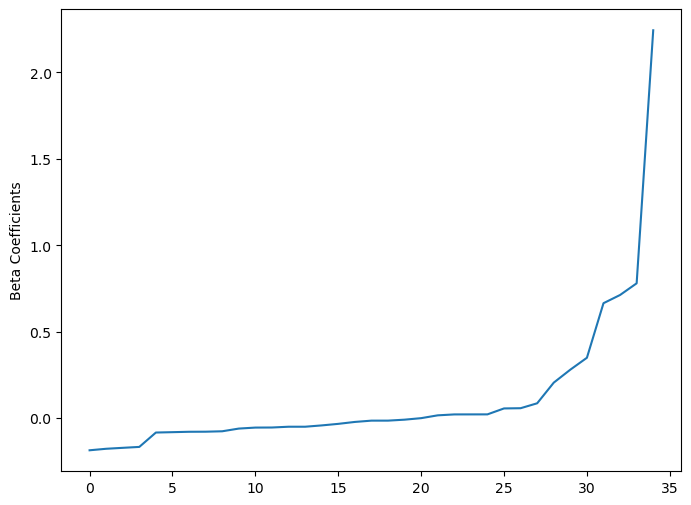

In [130]:
plt.rcParams["figure.figsize"] = (8,6)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

In [131]:
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

,coefs,vals,name
27,-0.185085,"[ME, VT, MA, IL, MD]",STATE_ind
11,-0.176380,"[Mixed Gender Household, Female Only Household...",Residence_HHGender_Description_ind
7,-0.170934,NaN,CommercialData_AreaPcntHHMarriedCoupleWithChil...
33,-0.165619,"[Y, U]",CommercialData_ComputerOwnerInHome_ind
23,-0.082488,"[Single Family Dwelling Unit, Multi-Family Dwe...",CommercialData_DwellingType_ind


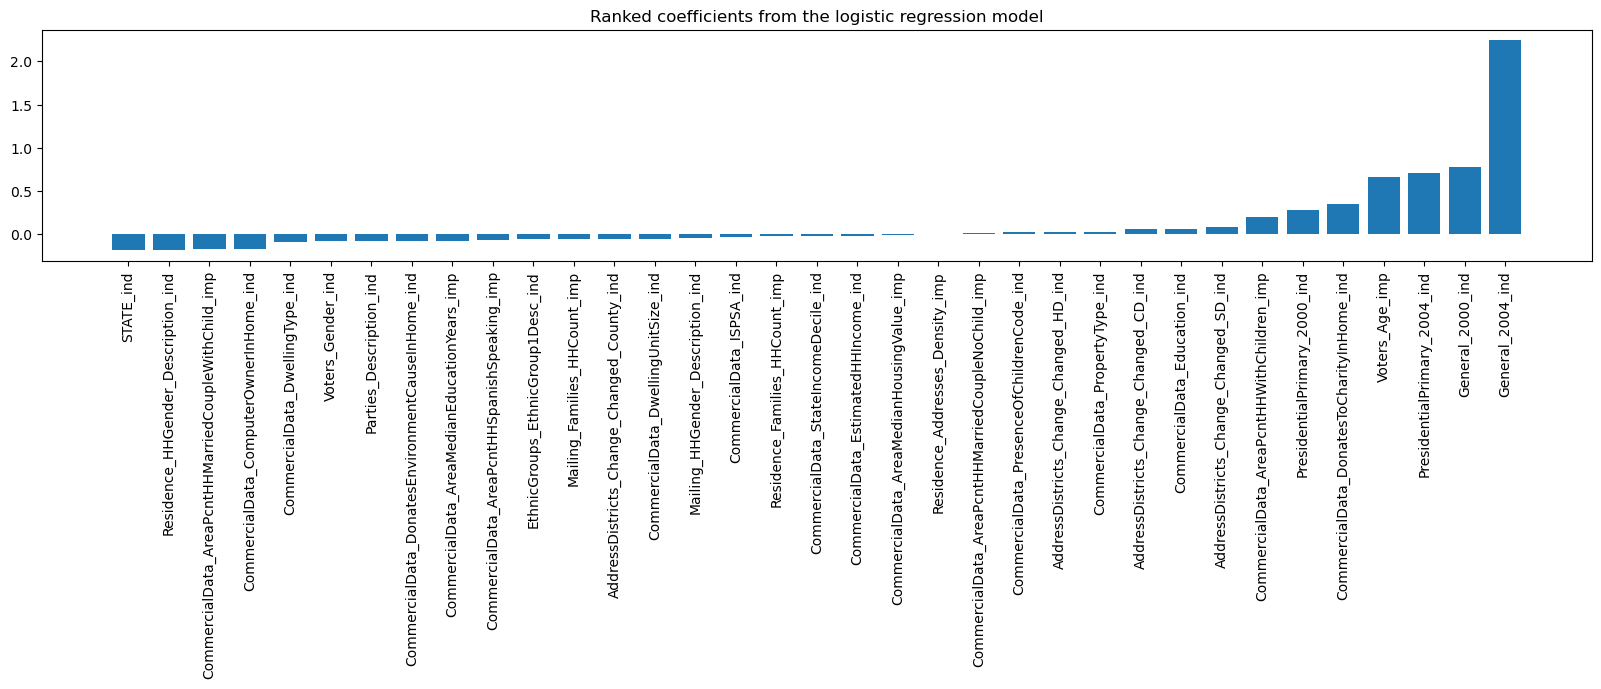

In [132]:
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()